## Feature Detection and Matching by Shawon Dey

In [1]:
import scipy.ndimage as ndi
import sys
import skimage
from skimage import io
from skimage import data
from skimage.feature import peak_local_max
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import get_ipython
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
#import cv2
import scipy
from scipy.ndimage import gaussian_filter
import time
import math

## Feature Detection with Harris corner detector


In [2]:
def showfeatures(ImageG):
    Ix = ndi.gaussian_filter(ImageG,sigma=1,order=(0,1))
    Iy = ndi.gaussian_filter(ImageG,sigma=1,order=(1,0))
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    GIxx = ndi.gaussian_filter(Ixx,sigma=2)
    GIyy = ndi.gaussian_filter(Iyy,sigma=2)
    GIxy = ndi.gaussian_filter(Ixy,sigma=2)
    Harris = (GIxx*GIyy-GIxy*2) - 0.05*(GIxx+GIyy)**2
    H = ((GIxx*GIyy-GIxy*2) - 0.05*(GIxx+GIyy)**2)- ((GIxx*GIyy-GIxy*2) - 0.05*(GIxx+GIyy)**2).min()
    H = H/H.max()
    
    
    keypoints = peak_local_max(H, min_distance=40,threshold_abs=0)
    keypoints1 = 1*keypoints
    
    for j in range(len(keypoints)):
        a,b = keypoints[j]
        ix = Ix[a,b]
        iy = Iy[a,b]
        keypoints1[j,0] = keypoints[j,0] + 100*iy
        keypoints1[j,1] = keypoints[j,1] + 100*ix
    
    DominantOrientaion = np.zeros(len(keypoints))
    for i in range(len(keypoints)):
        a,b = keypoints[i,:]
        r = math.atan((Iy/Ix)[a,b])
        ornt = (r*180)/np.pi
        DominantOrientaion[i] = ornt
    #return DO
    return keypoints,H,Ix,Iy,DominantOrientaion,keypoints1

C:\Users\shawo\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shawo\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


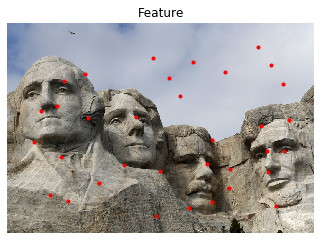

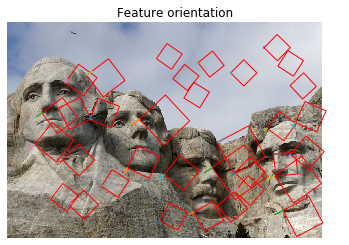

In [3]:
Image = io.imread('rushmore.jpg')
ImageG = skimage.color.rgb2gray(Image)
ImageGR = resize(ImageG, (int(ImageG.shape[0]*0.75), int(ImageG.shape[1]*0.75)),
                       anti_aliasing=True)
ImageR = resize(Image, (int(Image.shape[0]*0.75), int(Image.shape[1]*0.75)),
                       anti_aliasing=True)
keypoints,H,Ix,Iy,DominantOrientaion,key = showfeatures(ImageG)
keypoints1,H1,Ix1,Iy1,DominantOrientaion1,keypoints_line = showfeatures(ImageG)
keypoints2,H2,Ix2,Iy2,DominantOrientaion2,keypoints_line1 = showfeatures(ImageGR)
    
plt.figure(figsize = (5.5,5.5))
plt.imshow(Image,cmap = plt.cm.gray)
plt.plot(keypoints[:,1],keypoints[:,0],'r.')
plt.axis('off')
plt.title('Feature')    

fig,ax = plt.subplots(1)
ax.imshow(Image,cmap='gray')
for i in range(len(keypoints)):
    aa,bb = keypoints[i]
    #r = Box(Image,keypoints[i],100*(H[aa,bb]),Do1[i])
    a,b = keypoints[i,1],keypoints[i,0]
    size = 100*(H[aa,bb])
    angle = DominantOrientaion1[i]
    orientation = patches.Rectangle((a,b),size,size,angle,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(orientation)
    ax.plot([a,keypoints_line[i,1]],[b,keypoints_line[i,0]])
    ax.axis('off')
    plt.title('Feature orientation')

## My Descriptor. I tried to implement a SIFT like descriptor. Unfortunately my function is not so effective as SIFT.

In [13]:
def MyDescriptor(DominantOrientaion1,DominantOrientaion2,keypoints1,keypoints2,match):
    FinalDominantOrientaion1 = []
    FinalDominantOrientaion2 = []
    for i in range(len(DominantOrientaion1)):
        if abs(DominantOrientaion2[match] - DominantOrientaion1[i]) < abs(DominantOrientaion2[match])/5:
            FinalDominantOrientaion1.append(i) 
            FinalDominantOrientaion2.append(match)
    Delta1 = []
    Delta2 = []
    for i in range(len(FinalDominantOrientaion1)):
        d1 = DominantOrientaion1[FinalDominantOrientaion1[i]]
        d2 = DominantOrientaion2[FinalDominantOrientaion2[i]]
        sigma1 = np.where(DominantOrientaion1 == d1)
        sigma2 = np.where(DominantOrientaion2 == d2)

        localkey1 = keypoints1[sigma1]
        localkey2 = keypoints2[sigma2]
        localkey1 = localkey1[0]
        localkey2 = localkey2[0]
        Delta1.append(localkey1)
        Delta2.append(localkey2)

    Delta1 = np.array(Delta1)
    Delta2 = np.array(Delta2)

    Pixel1 = []
    Pixel2 = []
    for i in range(len(Delta1)):
        a,b=Delta1[i,:]
        p1=np.mean(Image[a-2:a+3,b-2:b+3])
        c,d=Delta2[i,:]
        p2=np.mean(ImageR[c-2:c+3,d-2:d+3])
        Pixel1.append(p1)
        Pixel2.append(p2)
    Pdelta = abs(np.array(Pixel1) - np.array(Pixel2))
    Ploc = np.argmin(Pdelta)
    ImageF1 = Delta1[Ploc]
    ImageF2 = Delta2[Ploc]
    return ImageF1,ImageF2,Delta1,Delta2

## Feature Matching

(-0.5, 599.5, 410.5, -0.5)

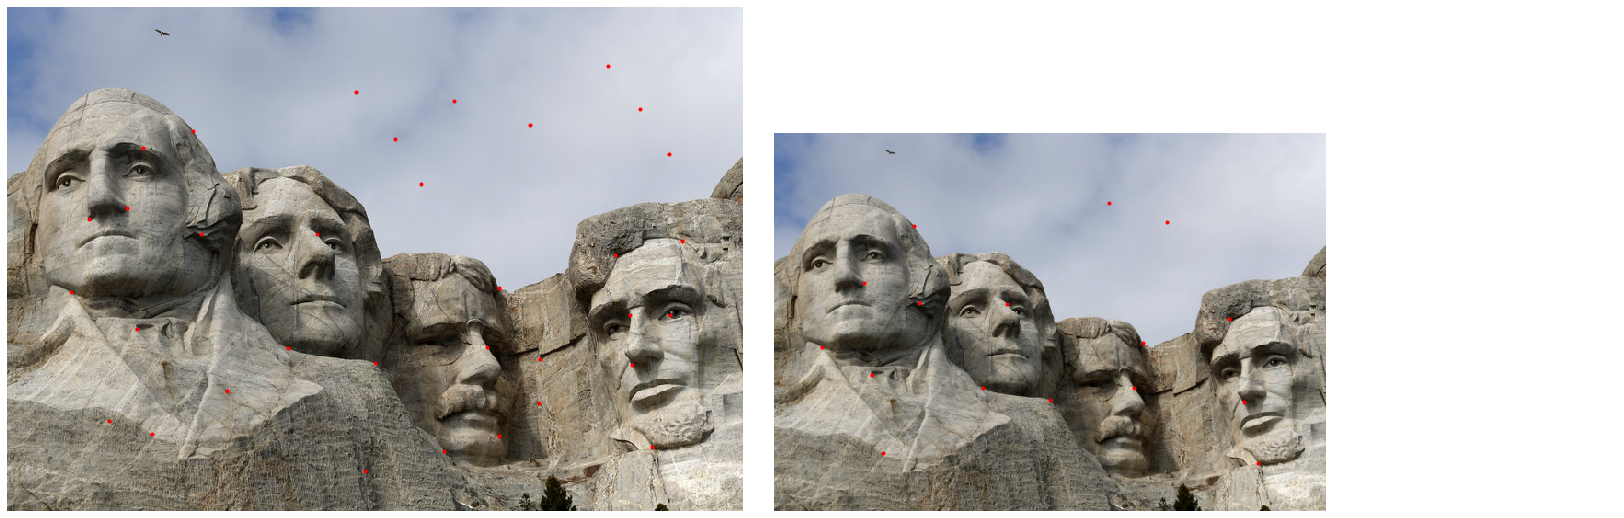

In [ ]:
ImageF1,ImageF2,Delta1,Delta2 = MyDescriptor(DominantOrientaion1,DominantOrientaion2,keypoints1,keypoints2,match=11)
fig, axes = plt.subplots(1,2,figsize=(15, 7),sharex=True, sharey=True)
for ax in axes:
    ax.axis('off')
aa1,bb1 = ImageF1
aa2,bb2 = ImageF2    
(ax0,ax1) = axes

ax0 = fig.add_axes((-0.75,0,1,1))
ax0.imshow(Image,cmap='gray')
ax0.plot(keypoints1[:,1],keypoints1[:,0],'r.')
ax1 = fig.add_axes((0,0,0.75,0.75))
ax1.imshow(ImageR,cmap='gray')
ax1.plot(keypoints2[:,1],keypoints2[:,0],'r.')
ax0.axis('off')
ax1.axis('off')
a,b = ImageF1[1],ImageF1[0]
r1 = patches.Rectangle((a,b),100*(H1[aa1,bb1]),100*(H1[aa1,bb1]),DominantOrientaion1[match],linewidth=1,edgecolor='r',facecolor='none')
match=11
a,b = ImageF2[1],ImageF2[0]
r2 = patches.Rectangle((a,b),100*(H1[aa2,bb2]),100*(H1[aa2,bb2]),DominantOrientaion2[match],linewidth=1,edgecolor='r',facecolor='none')
fig, axes = plt.subplots(1,2,figsize=(15, 7),sharex=True, sharey=True)
for ax in axes:
    ax.axis('off')
    
(ax0,ax1) = axes

ax0 = fig.add_axes((-0.75,0,1,1))
ax0.imshow(Image,cmap='gray')
ax0.plot(ImageF1[1],ImageF1[0],'r.')
ax0.add_patch(r1)
ax1 = fig.add_axes((0,0,0.75,0.75))
ax1.imshow(ImageR,cmap='gray')
ax1.plot(ImageF2[1],ImageF2[0],'r.')
ax1.add_patch(r2)

ax0.axis('off')
ax1.axis('off')
